<a href="https://colab.research.google.com/github/proteinovayas13/My_works/blob/main/Blending_House_Price_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решаю задачу регрессии методом Blending на прмере датасета цен на жилье.

In [ ]:
import numpy as np
import pandas as pd
from numpy import hstack
import seaborn as sns
from scipy.stats import norm

from numpy import mean
from numpy import std
from sklearn.ensemble import StackingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('train.csv')
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [ ]:
# Стандартное отклонение
stats = df.select_dtypes(include=['number']).agg(['mean', 'median', 'std'])
stats

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
median,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883


In [ ]:
df['SalePrice'].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


In [ ]:
df.isnull().sum().sort_values(ascending=False)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [ ]:
df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MiscFeature', 'Alley', 'LotFrontage'], axis=1, inplace=True)
df.drop(['Id'], axis=1)
df.head(5)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


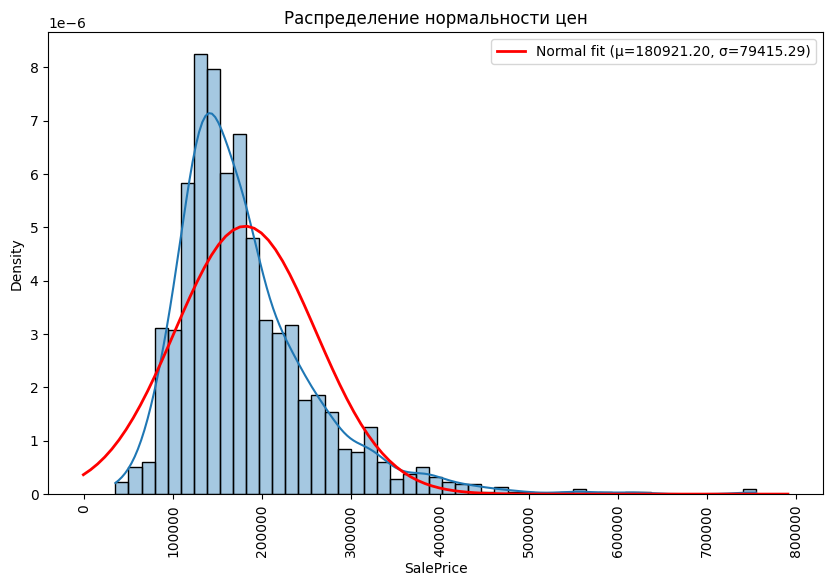

In [ ]:
plt.figure(figsize=(10, 6))

# Гистограмма с KDE
sns.histplot(df['SalePrice'], kde=True, stat='density', alpha=0.4)

# Подгонка нормального распределения
price_data = df['SalePrice'].to_numpy()  # Явное преобразование в numpy array
mu, std = norm.fit(price_data)  # Используем явно импортированную norm

# Построение кривой нормального распределения
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)  # Используем norm вместо stats.norm
plt.plot(x, p, 'r', linewidth=2, label=f"Normal fit (μ={mu:.2f}, σ={std:.2f})")

plt.xticks(rotation=90)
plt.legend()
plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Распределение нормальности цен')
plt.show()

In [ ]:
df['Log_SalePrice'] = np.log1p(df['SalePrice'])
df['Log_SalePrice'].skew()

np.float64(0.12134661989685333)

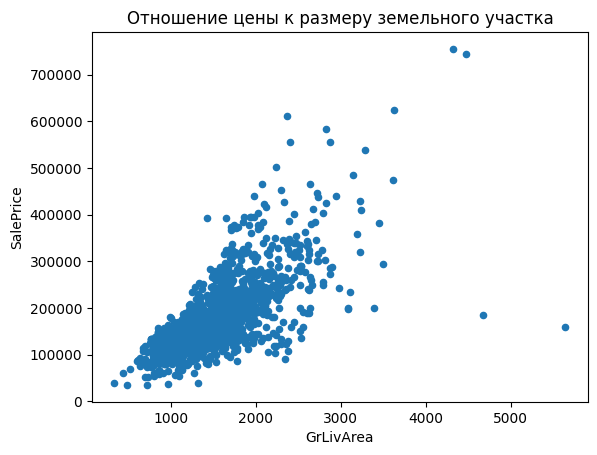

In [ ]:
# Отношение цены к размеру земельного участка
df.plot.scatter(x='GrLivArea', y='SalePrice')
plt.title('Отношение цены к размеру земельного участка')
plt.show()

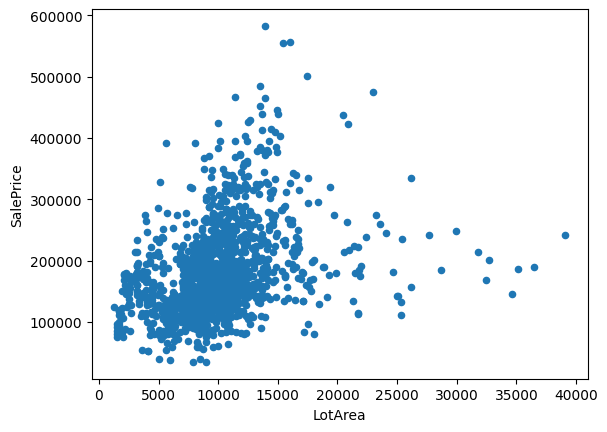

In [ ]:
df = df.drop(
    df[
        (df['LotArea'] > 40000) |
        (df['SalePrice'] > 600000)
    ].index
).reset_index(drop=True)

df.plot.scatter(x='LotArea', y='SalePrice')
plt.show()

In [ ]:
numerical_feats = df.dtypes[df.dtypes != 'object'].index
print('Number of Numerical features: ', len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == 'object'].index
print('Number of Categorical features: ', len(numerical_feats))

Number of Numerical features:  37
Number of Categorical features:  37


Выбор базовых моделей

In [ ]:
print(df[numerical_feats].columns)
print('*'*100)
print(df[numerical_feats].columns)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
****************************************************************************************************
Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvG

In [ ]:
y = df.SalePrice
df.drop(['SalePrice'], axis=1, inplace=True)

In [ ]:
# Выбираем столбцы только с числовыми значениями
numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['float64', 'int64']]
X = df[numeric_cols].copy()

In [ ]:
# Убедимся, что все NaN заменены на среднее
X = X.fillna(X.mean()) if isinstance(X, (pd.DataFrame, pd.Series)) else np.where(np.isnan(X), np.nanmean(X), X)
y = y.fillna(y.mean()) if isinstance(y, (pd.DataFrame, pd.Series)) else np.where(np.isnan(y), np.nanmean(y), y)

In [ ]:
print(f"Размер X до обработки: {df[numeric_cols].shape}")
print(f"Размер y до обработки: {y.shape}")

Размер X до обработки: (1442, 36)
Размер y до обработки: (1442,)


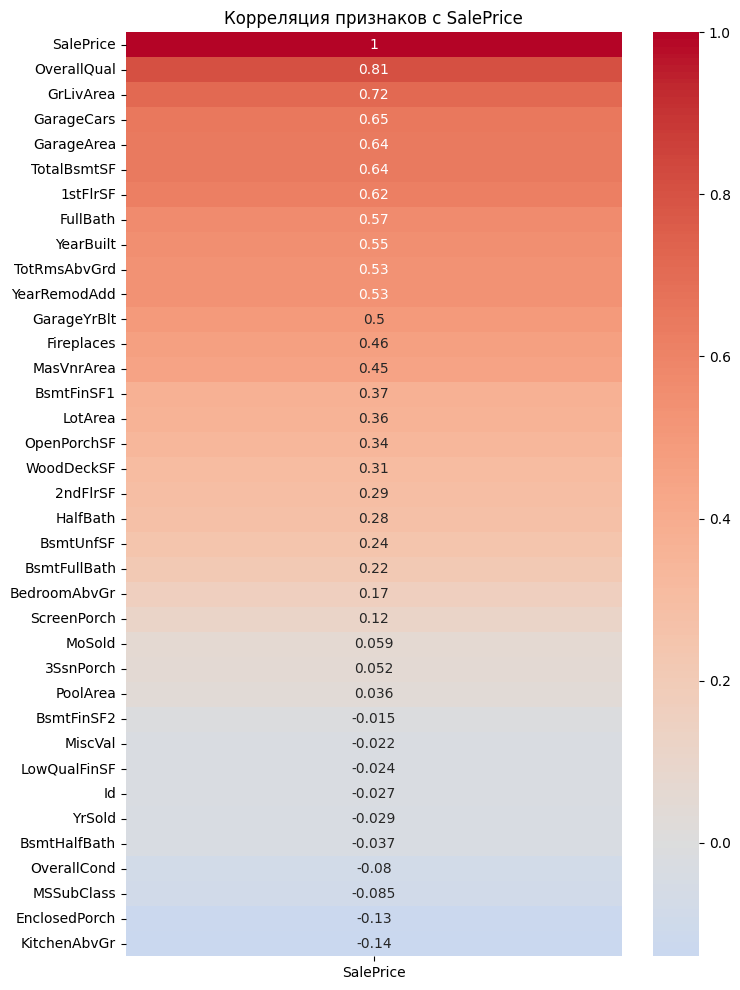

In [ ]:
df = pd.concat([X, y], axis=1)

# Вычисляем корреляции с SalePrice
correlation_with_target = df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)

# Визуализируем
plt.figure(figsize=(8, 12))
sns.heatmap(correlation_with_target, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция признаков с SalePrice')
plt.show()

In [ ]:
# Разделение данных на тестовую и остальную выборки
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
# Разделение полученной выборки на обучающую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.33, random_state=1)

print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))

Train: (483, 36), Val: (238, 36), Test: (721, 36)


# Выбор базовых моделей

In [ ]:
def get_models():
  models = list()
  models.append(('LinearRegression', LinearRegression()))
  models.append(('XGBoost', XGBRegressor()))
  models.append(('KNeighbors', KNeighborsRegressor()))
  models.append(('RandomForestRegressor', RandomForestRegressor()))
  return models

models = get_models()

Решение с помощью базовых моделей


In [ ]:
# evaluate standalone model
for name, model in models:
    # fit the model on the training dataset
    model.fit(X_train_full, y_train_full)
    # make a predictions
    y_pred = model.predict(X_test)
    # make apredictions
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # report the score
    print(f'>{name} - R2: {r2:.3f} - MAE: {mae:.3f}')

>LinearRegression - R2: 0.933 - MAE: 12265.106
>XGBoost - R2: 0.992 - MAE: 1623.056
>KNeighbors - R2: 0.631 - MAE: 31485.851
>RandomForestRegressor - R2: 0.991 - MAE: 1037.522


In [ ]:
def fit_ensemble(models, X_train, X_val, y_train, y_val):
  meta_X = list()
  for name, model in models:
    # Обучение модели на трейн данных
    model.fit(X_train, y_train)
    # Прогноз, формирование мета признаков
    y_pred = model.predict(X_val)
    # Приводим признаки в матричный вид
    y_pred = y_pred.reshape(len(y_pred), 1)
    # Накапливаем в переменной meta_X
    meta_X.append(y_pred)
   # Формируем массив для мета-признаков по всем моделям
  meta_X = hstack(meta_X)
  # Строим мета модель
  blender = LogisticRegression()
  # Обучаем мета модель
  blender.fit(meta_X, y_val)
  return blender

# Обучаем мета модель на валидационных жанных
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)

# Прогнозирование с помощью блендинга


In [ ]:
# Обучение и прогноз на тестовых данных
def predict_ensemble(models, blender, X_test):
  # make predictions with base models
  meta_X = list()
  for name, model in models:
    # Для каждой базовой модели строим прогноз на тестовых данных
    y_pred = model.predict(X_test)
    # Приводим признаки в матричный вид
    y_pred = y_pred.reshape(len(y_pred), 1)
    # Накапливаем в переменной meta_X
    meta_X.append(y_pred)
   # Формируем массив для мета-признаков по всем моделям
  meta_X = hstack(meta_X)
  # Строим прогноз мета-модель по полученным признакам
  return blender.predict(meta_X)

# Прогноз мета модели на тестовых данных
y_pred = predict_ensemble(models, blender, X_test)

Оценка точности

In [ ]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'>Blending - R2: {r2:.3f} - MAE: {mae:.3f}')

>Blending - R2: 0.459 - MAE: 40320.330


Вывод

Целевая переменная SalePrice лучше всего коррелирует с площадью участка ( LotArea )

Лучшую метрику показывает LinearRegression - R2: 0.933 - MAE: 12265.106

Результаты блендинга показывают оптимистичный результат Blending - R2: 0.459 - MAE: 40320.330
